# Hyperparameter search over CNN model based on 5-fold cross-validation
Performs a search over the hyperparameter space for the CNN model to try and find a more optimal parameter configuration.

User c is completely removed as this is the test set.

The remaining users A,B,D,E and F make up each fold.

For example, fold 1 will train on users B,D,E and F then evaluate on A (and so on for each fold).

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Plot graphs inline
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

Import remaining packages

In [3]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# needed for CheckpointSaver (not in release yet but very useful)
# https://github.com/scikit-optimize/scikit-optimize/issues/678
# ! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
    
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import dump, load

In [5]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

In [6]:
RUN_SEARCH = False
SAVE_GRAPHS = False

## Experiment Setup

In [7]:
target_names = ["walking", "pushing", "sitting", "pulling",
                "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75
# user c excluded as this is reserved for final evaluation
users = ["A", "B", "D", "E", "F"] 

In [8]:
def load_data(user_letter):
    """
    load the data and labels associated with a particular user/subject (interchangeable)
    :param user_letter: Letter representing subject/user (A-F)
    :type user_letter: str
    :return: data and labels
    :rtype: tuple of the form (data, labels)
    """
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

        
    return data, labels

In [9]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

In [10]:
def split_train_validation(validation_user):
    """
    Splits the data into a train and validation set.
    The validation set is composed of the subject specified, the training set of the remaining subjects.
    :param validation_user: Subject to use for validation set (A-F)
    :type validation_user: str
    :return: data and labels for the train and validation set
    :rtype: dictionary with keys "train_data", "train_labels", "validation_data" and "validation_labels"
    """
    train_data = None
    train_labels = None
    first_round = True
    validation_data = []
    validation_labels = []
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        if user == validation_user:
            validation_data = data
            validation_labels = labels
            
        else:
            if first_round:
                train_data = data
                train_labels = labels
                first_round = False
            else:
                train_data = np.concatenate((train_data, data))
                train_labels = np.concatenate((train_labels, labels))
            
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    train_data = train_data.astype('float32')
    validation_data = validation_data.astype('float32')
    train_data /= 255
    validation_data /= 255 
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels
       }

## Define Model

In [11]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    """
    Make and return the CNN model
    :param nb_filters: Number of filters to use in layers 1,2 and 3,4 respectively
    :type nb_filters: str containing the number of filters for the first two layers followed by 
    the last two layers, for example: "16-32"
    :param img_rows: image height
    :type img_rows: int
    :param img_cols: image width
    :type img_cols: int
    :param nb_classes: Number of classes to be predicted
    :type nb_classes: int
    :param activation: Activation function to use after each conv and dense layer
    :type activation: Keras activation function
    :param dropout: dropout rate for dropout layers
    :type dropout: float
    :param num_dense_nodes: number of dense nodes in dense layer
    :type num_dense_nodes: int
    :param num_dense_layers: number of dense layers
    :type num_dense_layers: int
    :param kernel_size: kernel size to use
    :type kernel_size: int but will be converted to tuple (int, int) 
                        internally as kernel is a square
    :param pooling_size: pool size
    :type pooling_size: int but will be converted to tuple (int, int)
                        internally as requires vertical and horizontal
    :return: CNN model
    :rtype: Keras sequential model
    """
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same',
                            input_shape=(1, img_rows, img_cols),
                            activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same',
                            activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Hyperparameter Search

### Fixed Parameters

In [12]:
nb_epoch = 30  # 30

### Parameters to Search

In [13]:
space = [
    Categorical(['adam', 'sgd_standard', 'sgd_nestrov'], name='optimizer'),
    Real(0.0001, 0.1, "log-uniform", name='learning_rate'),
    Categorical(['relu', 'sigmoid', 'tanh'], name='activation'),
    Real(0.1, 0.9, name='dropout'),
    Integer(16, 1024, name='num_dense_nodes'),
    Integer(1, 3, name='num_dense_layers'),
    Integer(2, 5, name='kernel_size'),
    Integer(2, 4, name='pooling_size'),
    Integer(8, 1024, name='batch_size')
]

### Objective Function to Minimize

In [14]:
@use_named_args(space)
def objective(**params):
    """
    Objective function to be minimised during search. Returns negative average validation accuracy from five folds.
    Negative returned as function is minimised.
    :return: -(average validation accuracy from five-fold cross-validation)
    :rtype: float
    """
    average_accuracy = 0
    average_loss = 0
    for user in users:
        data_split = split_train_validation(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]

        model = make_model("8-16", img_rows, img_cols, nb_classes,
                           params["activation"], params['dropout'],
                           params['num_dense_nodes'],
                           params['num_dense_layers'], params['kernel_size'],
                           params['pooling_size'])
        if params['optimizer'] == 'adam':
            selected_optimizer = Adam(lr=params['learning_rate'])
            
        elif params['optimizer'] == 'sgd_standard':
            selected_optimizer = SGD(lr=params['learning_rate'])
            
        else:
            # nestrov momentum
            selected_optimizer = SGD(lr=params['learning_rate'], decay=1e-6, 
                                     momentum=0.9, nesterov=True)
            
        model.compile(loss='categorical_crossentropy',
                      optimizer=selected_optimizer,
                      metrics=['accuracy'])

        model.fit(
            train_data,
            train_labels,
            batch_size=params['batch_size'],
            epochs=nb_epoch,
            shuffle=True, 
            verbose=1)

        evaluation = model.evaluate(validation_data, validation_labels,
                                    batch_size=params['batch_size'], verbose=0)

        average_loss += evaluation[0]
        average_accuracy += evaluation[1]
        
    return -(average_accuracy/len(users))  # return negative as minimizing

### Callbacks

In [15]:
checkpoint = CheckpointSaver(RESULTS_PATH + "res_gp_checkpoint.pkl")
callbacks_list = [checkpoint]

### Load checkpoint
Used if search was interupted before it could finish

In [16]:
LOAD_CHECKPOINT = False

In [17]:
if LOAD_CHECKPOINT:
    res = load(RESULTS_PATH + "res_gp_checkpoint.pkl")
    x0 = res.x_iters
    y0 = res.func_vals
    
else:
    x0 = None
    y0 = None

### Perform Search

In [18]:
if RUN_SEARCH:
    res_gp = gp_minimize(objective, space, x0=x0, y0=y0,
                         n_calls=122, n_random_starts=10,
                         random_state=0, callback=callbacks_list)

### Save gp results

In [19]:
if RUN_SEARCH:
    dump(res_gp, RESULTS_PATH + "res_gp_complete.pkl")

### Load gp results

In [20]:
res_gp = load(RESULTS_PATH + "res_gp_complete.pkl")

## Results

Best Hyperparameters Discovered

In [21]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size','batch_size']
parameters = res_gp.x
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

optimizer: adam
learning_rate: 0.0012375685948764468
activation: relu
dropout: 0.597428888669298
num_dense_nodes: 1024
num_dense_layers: 3
kernel_size: 3
pooling_size: 2
batch_size: 576


In [22]:
print("Highest average accuracy over 5-folds achieved:", str(round(-res_gp.fun*100, 2))+"%")

Highest average accuracy over 5-folds achieved: 78.4%


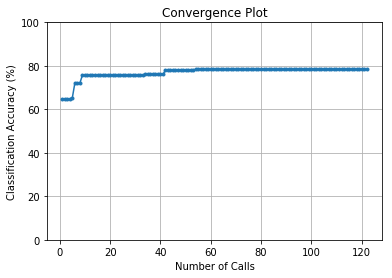

In [23]:
# adapted from skopt.plots.plot_convergence
n_calls = len(res_gp.x_iters)
mins = [np.min(res_gp.func_vals[:i])
        for i in range(1, n_calls + 1)]
plt.plot(range(1, n_calls + 1), -np.array(mins)*100, marker='.')
plt.title("Convergence Plot")
plt.ylabel("Classification Accuracy (%)")
plt.xlabel("Number of Calls")
plt.ylim(0,100)
plt.grid()
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "convergence_plot.pdf", format='pdf')

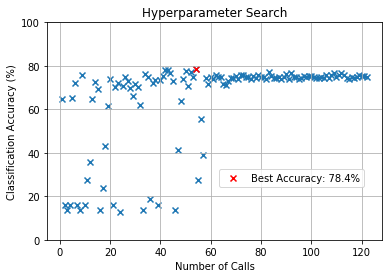

In [24]:
plt.scatter(range(1, n_calls + 1), -(np.array(res_gp.func_vals)*100), marker='x')
plt.scatter([np.argmin(res_gp.func_vals)+1],[-res_gp.fun*100],
            marker='x', color='red',
            label="Best Accuracy: " + str(round(-res_gp.fun*100, 2))+"%")
plt.legend(bbox_to_anchor=(0.5,0.35), loc="upper left")
plt.ylabel("Classification Accuracy (%)")
plt.xlabel("Number of Calls")
plt.ylim(0,100)
plt.grid()
plt.title("Hyperparameter Search")
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "hyperparameter_search.pdf", format='pdf')